# Train model

This notebook is to train the model.
1. First, some feature engineering is conducted to prepare the dataset and add the more details possible.
2. Then, a first model is trained using cross validation and expanding window validation to validate the model. The model and info are loaded to MLflow to store the different models and track the performances.
3. Finally, the best model is run on the entire train set.

# 1. Imports

## 1.1 Packages

In [281]:
import os
import pandas as pd
import sys

In [282]:
# Load custom functions
sys.path.append("../src/")
from prepare_data import get_holidays
from feature_engineering import extract_date_features, add_lockdown_periods, add_holidays_period,\
    get_split_train_val_cv, get_split_cv_by_week
from train_model import train_model_cv_mlflow, train_model, create_pool, save_model

## 1.2 Options

In [283]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
# Define some parameters

path_data = "../data/processed"

feat_date = "Date"

## 1.3 Datasets

In [285]:
# Load the train set and its target

df_train = pd.read_pickle(os.path.join(path_data, "train.pkl"))
y_train = pd.read_csv(os.path.join(path_data, "target_train.csv"), index_col=0)

# 2. Prepare data

## 2.1 Feature engineering

To prepare data, the following feature engineering is done:
1. Extract info from date: year, month, day, day of the week and if its weekend or not
2. Add an indicator of the lockdown period: if there was a lockdown, and which one (first, second or thrid one)
3. Add holidays period for Zone A in France
4. Add holidays period for Zone B in France
5. Add holidays period for Zone C in France

(Having some geographical information could let us add just the right holidays period depending on the zone)

6. Drop columns Date and Fourni which will not be used in the model

In [286]:
df_date_train = df_train[feat_date]

df_train = df_train.pipe(extract_date_features, feat_date=feat_date)\
    .pipe(add_lockdown_periods, feat_date=feat_date)\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone A")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone B")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone C")\
    .drop(columns=[feat_date, "Fourni"])

In [287]:
df_train

,id,Date_year,Date_month,Date_day,Date_weekday,Date_weekend,lockdown,Description_ZoneA,Description_ZoneB,Description_ZoneC
91,-6795017860123346820,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
71,4324517785573311838,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
70,5056562842583071429,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
68,-5277685202972058648,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
67,4079792561055568638,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
...,...,...,...,...,...,...,...,...,...,...
64186,6858783929733742556,2022,6,20,0,0,0,None,None,None
64187,2132453013379446212,2022,6,20,0,0,0,None,None,None
64189,8884923748487096025,2022,6,20,0,0,0,None,None,None
64221,2942031581314612067,2022,6,20,0,0,0,None,None,None


In [288]:
# Define the categorical columns for the model
feat_cat = ["id", "Date_weekend", "lockdown", "Description_ZoneA", "Description_ZoneB", "Description_ZoneC"]

## 2.2 Split into folds

The train set is split into folds using expanding window validation. It means, we select one portion of the set as the train set, and the portion after as the validation. Then the validation set is added to the train set and a period after is the new validation set, and so on.

We consider that we need to predict the number of sales one week before in order to prepare everything (printing, delivery, etc.). Therefore, each window represents one week.

In [289]:
# Split the train set into different folds
list_train_valid = get_split_cv_by_week(df_train.copy(), df_date_train, feat_date=feat_date, target=y_train, n_splits=5)

# 3. Train model

## 3.1 Cross validation and hyperparameters search

Cross validation is used to train a model and analyze the performance on different windows.

For the hyperparameters search, MLflow is used to track the different tests and save models. We log the hyperparameters, the metrics, and SHAP values to MLflow to save between the different runs.



__Run info__:

The first metric used was RMSE. However, the goal is to limit the number of sold outs, a quantile metric has better performance.

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


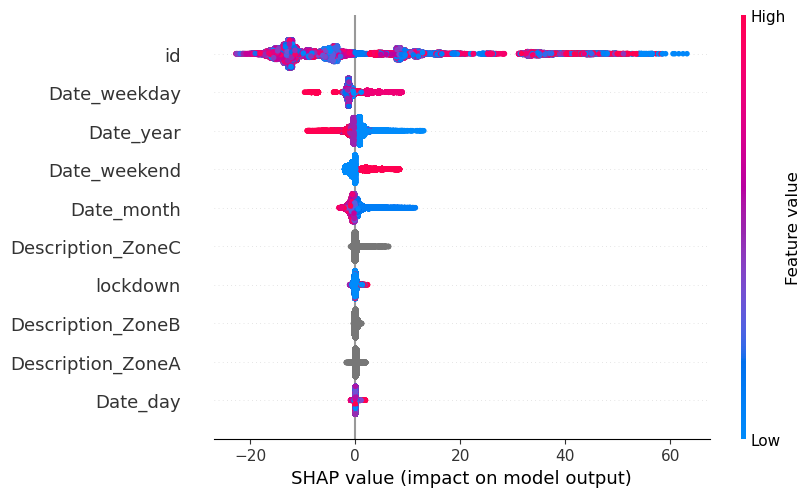

In [290]:
params = {
    "iterations": 1000,
    "depth": 7,
    # "loss_function": "RMSE",
    "loss_function": "Quantile:alpha=0.95",
    # "learning_rate": 0.07,
    "early_stopping_rounds": 100,
}

model, pred_train, pred_valid = train_model_cv_mlflow(
    list_train_valid=list_train_valid,
    feat_cat=feat_cat, plot_training=False, verbose=0,
    **params
)

## 3.2 Final model

Train a final model on the entire train set using the hyperparameters selected by the previous runs

In [294]:
params_final = params
params_final["learning_rate"] = model.get_all_params()["learning_rate"]
params_final["iterations"] = model.get_best_iteration()
print(params_final)

pool_train = create_pool(df_train, y_train, feat_cat=feat_cat)
model_final = train_model(pool_train=pool_train, pool_eval=None, plot_training=True, verbose=100, **params_final)
save_model(model_final, features=df_train.columns.tolist(), feat_cat=feat_cat, path="../models/model_final.json")

{'iterations': 472, 'depth': 7, 'loss_function': 'Quantile:alpha=0.95', 'early_stopping_rounds': 100, 'learning_rate': 0.029999999329447743}


iteritems is deprecated and will be removed in a future version. Use .items instead.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9599080	total: 11.4ms	remaining: 5.36s


You should provide test set for use best model. use_best_model parameter has been switched to false value.


100:	learn: 1.7935366	total: 1.74s	remaining: 6.39s
200:	learn: 1.7752740	total: 3.41s	remaining: 4.6s
300:	learn: 1.7649944	total: 4.94s	remaining: 2.8s
400:	learn: 1.7612302	total: 6.41s	remaining: 1.14s
471:	learn: 1.7599688	total: 7.56s	remaining: 0us
